# Pre-process data from multipe datasets to get data annual precip stats over South America

In [41]:
import cartopy.crs as ccrs
import intake
import uxarray as ux
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import healpix as hp
import easygems.healpix as egh
import easygems as egm
import xarray as xr
import cmocean
import matplotlib as mpl

## Compare datasets based on availability in the HEALPix format

| Dataset   | Variable           | Long Name                            | Units           | Frequency available | Comments                                                        |
|-----------|--------------------|--------------------------------------|-----------------|-----------|-----------------------------------------------------------------|
| ERA5      | `tp`               | Total precipitation                  | m               | Monthly    | Monthly mean precipitation|
| JRA3Q     | `mtpr`             | Mean total precipitation rate        | kg m⁻² s⁻¹      | Monthly     | Daily mean total precipitation rate; hourly data available as `tprate` |
| IMERG     | `precipitation` | Precipitation rate        | mm hr⁻¹         | 30 min    | Half-hourly precipitation intensity |
| WRF-SAAG  | `pr`               | Total precipitation flux             | kg m⁻² s⁻¹      | Hourly    | Accumulated precipitation flux; difference successive outputs for rates |

In [2]:
# Define the period of interest
start, end = '2020-01-01', '2020-12-31'

In [3]:
cat_url = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
cat = intake.open_catalog(cat_url).NCAR
cat

NCAR:
  args:
    path: https://digital-earths-global-hackathon.github.io/catalog/NCAR/catalog.yaml
  description: catalog as visible from NCAR
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://digital-earths-global-hackathon.github.io/catalog


In [4]:
list(cat)

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'arp-gem-1p3km',
 'arp-gem-2p6km',
 'casesm2_10km_nocumulus',
 'ew_dyamond3_2D',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'ifs_tco3999_rcbmf',
 'mpas_dyamond1',
 'mpas_dyamond2',
 'mpas_dyamond3',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3',
 'wrf_conus',
 'wrf_samerica']

## Get seasonal precipitation intensity data from different models and obs

### Obtain data

In [5]:
## Seasonal max precip over South America in 2020 ?

In [6]:
zoom_level = 9

In [7]:
%%time
ds_wrf_saag = cat.wrf_samerica(zoom=zoom_level).to_dask()
ds_wrf_saag

CPU times: user 1.62 s, sys: 76.4 ms, total: 1.7 s
Wall time: 1.79 s


/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 291GB
Dimensions:   (cell: 394546, Time: 8784)
Coordinates:
  * cell      (cell) int64 3MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs       float32 4B nan
  * Time      (Time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Data variables: (12/22)
    LANDMASK  (cell) float32 2MB dask.array<chunksize=(65536,), meta=np.ndarray>
    clivi     (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    clwvi     (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    hflsd     (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    huss      (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    pr        (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    ...        ...
    rsutcs    (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    sncvfa    (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    swe       (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    tas       (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    uas       (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
    vas       (Time, cell) float32 14GB dask.array<chunksize=(48, 65536), meta=np.ndarray>
Attributes:
    FieldType:      104
    MemoryOrder:    XY 
    cell_methods:   Time: mean
    description:    LAND MASK (1 FOR LAND, 0 FOR WATER)
    domain_extent:  (np.float32(-98.46912), np.float32(-17.530884), np.float3...
    grid_mapping:   healpix_nested
    healpix_nside:  512
    regrid_method:  easygems_delaunay
    stagger:        
    units:

In [8]:
da_wrf_saag = ds_wrf_saag.pr
da_wrf_saag = da_wrf_saag.rename({'Time':'time'})
# da_wrf_saag

In [9]:
da_wrf_saag = da_wrf_saag.sel(time=slice(start,end))
da_wrf_saag

<xarray.DataArray 'pr' (time: 8784, cell: 394546)> Size: 14GB
dask.array<getitem, shape=(8784, 394546), dtype=float32, chunksize=(48, 65536), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 3MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float32 4B nan
  * time     (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Attributes:
    domain_extent:  (np.float32(-98.46912), np.float32(-17.530884), np.float3...
    grid_mapping:   healpix_nested
    healpix_nside:  512
    regrid_method:  easygems_delaunay

In [10]:
# da_wrf_saag.values

In [11]:
# ds_era5 = cat.ERA5(zoom=zoom_level).to_dask()
# da_era5 = ds_era5.tp
# da_era5 = da_era5.sel(time=slice(start,end))
# da_era5

In [12]:
# %%time
# # Has data from 2019 Aug 1 to 2020 Sep 1
# ds_scream2d = cat.scream2D_hrly(zoom=zoom_level).to_dask()
# da_scream2d = ds_scream2d.pr
# da_scream2d

In [38]:
# %%time
# ds_jra3q = cat.JRA3Q(zoom=zoom_level).to_dask()
# da_jra3q = ds_jra3q.mtpr
# da_jra3q = da_jra3q.sel(time=slice(start,end))
# da_jra3q

In [14]:
ds_imerg = cat.IR_IMERG(zoom= 9).to_dask()
da_imerg = ds_imerg.precipitation
da_imerg = da_imerg.sel(time = slice(start,end))
da_imerg

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.DataArray 'precipitation' (time: 17568, cell: 3145728)> Size: 221GB
dask.array<getitem, shape=(17568, 3145728), dtype=float32, chunksize=(1, 3145728), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    crs      float64 8B ...
  * time     (time) datetime64[ns] 141kB 2020-01-01 ... 2020-12-31T23:30:00
Attributes:
    CodeMissingValue:  -9999.9
    DimensionNames:    time,lon,lat
    LongName:          \nComplete merged microwave-infrared (gauge-adjusted)\...
    Units:             mm/hr
    fullnamepath:      /Grid/precipitation
    long_name:         precipitation
    origname:          precipitation
    units:             mm/hr

## Convert to HEALPIX

In [15]:
# da_wrf_saag.values

In [16]:
# ux_era5     = ux.UxDataset.from_healpix(da_era5.to_dataset(name='tp'))
# ux_jra3q    = ux.UxDataset.from_healpix(da_jra3q.to_dataset(name='mtpr'))
# ux_imerg    = ux.UxDataset.from_healpix(da_imerg.to_dataset(name='precipitation'))
# ux_wrf_saag = ux.UxDataset.from_healpix(da_wrf_saag.to_dataset(name='pr'))

In [17]:
# # 2. Pull out the UxDataArray for each variable
# da_era5_ux  = ux_era5['tp']
# da_jra3q_ux = ux_jra3q['mtpr']
# da_imerg_ux = ux_imerg['precipitation']
# da_wrf_ux   = ux_wrf_saag['pr']
# # da_wrf_ux

### Subset to South America

In [18]:
# 3. Define South America bounding box and subset
lon_bounds = (-90, -30)
lat_bounds = (-60,  15)
lat_start = 15
lat_end   = -60
lon_start = (360-90)%360
lon_end   = (360-30)%360
lon_end

330

In [19]:
# sa_jra3q = da_jra3q.sel(latitude = slice(lat_start,lat_end),longitude= slice(lon_start,lon_end))
# sa_jra3q

In [20]:
# %%time
# sa_era5  = da_era5_ux.subset.bounding_box(lon_bounds, lat_bounds)  
# sa_jra3q = da_jra3q_ux.subset.bounding_box(lon_bounds, lat_bounds) 
# sa_imerg = da_imerg_ux.subset.bounding_box(lon_bounds, lat_bounds) 
# sa_wrf   = da_wrf_ux.subset.bounding_box(lon_bounds, lat_bounds)   
# sa_wrf

In [21]:
# sa_wrf.values

### Computations

#### Use UXarray for subsetting

In [22]:
%%time
ux_imerg    = ux.UxDataset.from_healpix(da_imerg.to_dataset(name='pr'))
da_imerg_ux = ux_imerg['pr']
sa_imerg    = da_imerg_ux.subset.bounding_box(lon_bounds, lat_bounds) 
# sa_imerg

CPU times: user 27.9 s, sys: 607 ms, total: 28.5 s
Wall time: 5.68 s


In [23]:
## Resample to hourly and take max
sa_imerg_hr = sa_imerg.resample(time='h').sum()
sa_imerg_hrmax = sa_imerg_hr.max(dim='time')

In [24]:
sa_imerg_hrmax

<xarray.UxDataArray 'pr' (n_face: 293587)> Size: 1MB
dask.array<_nanmax_skip-aggregate, shape=(293587,), dtype=float32, chunksize=(293587,), chunktype=numpy.ndarray>
Coordinates:
    cell     (n_face) int64 2MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float64 8B ...
Dimensions without coordinates: n_face

In [25]:
## # 4) WRF-SAAG: pr already seems to be in mm/s 
# (by inspecting the values)
sa_wrf_mm  = da_wrf_saag*3600
sa_wrf_hrmax = sa_wrf_mm.max(dim='time')
sa_wrf_hrmax

<xarray.DataArray 'pr' (cell: 394546)> Size: 2MB
dask.array<_nanmax_skip-aggregate, shape=(394546,), dtype=float32, chunksize=(65536,), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 3MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float32 4B nan

In [26]:
### Rename n_face to cell
sa_imerg_hrmax = sa_imerg_hrmax.rename({'n_face': 'cell'})

/glade/derecho/scratch/harshah/tmp/ipykernel_68941/39560302.py:2: UserWarning: rename 'n_face' to 'cell' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  sa_imerg_hrmax = sa_imerg_hrmax.rename({'n_face': 'cell'})


In [27]:
sa_imerg_hrmax

<xarray.UxDataArray 'pr' (cell: 293587)> Size: 1MB
dask.array<_nanmax_skip-aggregate, shape=(293587,), dtype=float32, chunksize=(293587,), chunktype=numpy.ndarray>
Coordinates:
    cell     (cell) int64 2MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float64 8B ...

In [28]:
### Convert uxda to xr.da
sa_imerg_hrmax = xr.DataArray(data=sa_imerg_hrmax.data,dims=['cell'],coords={'cell':sa_imerg_hrmax.cell,'crs':sa_imerg_hrmax.crs})
print(sa_imerg_hrmax)

<xarray.DataArray '_nanmax_skip-aggregate-ffbf440f67f053137fecc19e87e39f91' (
                                                                             cell: 293587)> Size: 1MB
dask.array<_nanmax_skip-aggregate, shape=(293587,), dtype=float32, chunksize=(293587,), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 2MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float64 8B ...


In [29]:
# # 1) ERA5: tp in m → mm, then monthly sum
# sa_era5_mm   = sa_era5 * 1000
# sa_era5_mon  = sa_era5_mm

# # 2) JRA-3Q: mtpr in kg m⁻² s⁻¹ = mm s⁻¹ → mm per day (but, monthly sum as already been performed)
# #    daily mean rate * 86400 s/day → mm/day  
# seconds_per_month = da_jra3q.time.dt.days_in_month * 24 * 3600
# da_jra3q_mm       = da_jra3q* seconds_per_month
# da_jra3q_mon      = da_jra3q_mm

# 3) IMERG: precip in mm/hr → mm per half-hour, then monthly sum
#
# da_imerg_hr  = da_imerg.resample(time='H').sum()
# da_imerg_mon = da_imerg_mm.resample(time="ME").sum()

# # 4) WRF-SAAG: pr already seems to be in mm/s 
# # (by inspecting the values)
# da_wrf_saag_mm  = da_wrf_saag*3600

In [30]:
# %%time
# da_wrf_saag_mm.isel(time=700).values

NameError: name 'da_wrf_saag_mm' is not defined

In [31]:
%%time
da_imerg.isel(time=500).values

CPU times: user 96 ms, sys: 20.1 ms, total: 116 ms
Wall time: 1.33 s


array([0., 0., 0., ..., 0., 0., 0.], shape=(3145728,), dtype=float32)

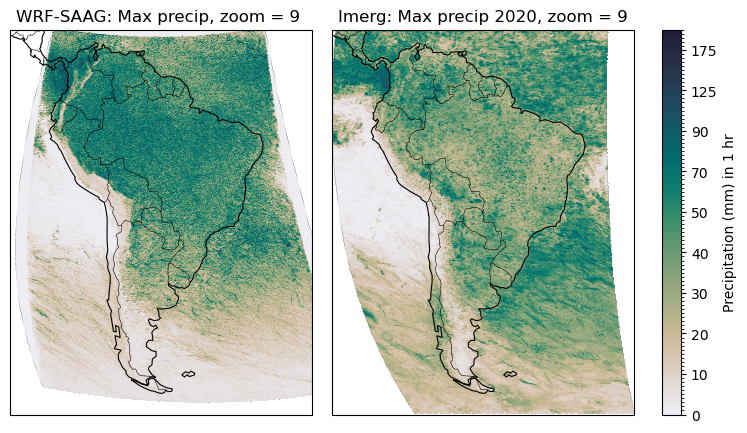

CPU times: user 5min 16s, sys: 48.4 s, total: 6min 4s
Wall time: 9min 26s


In [44]:
%%time
# Max precip (max taken over hourly and 30 min data)
fig, axs = plt.subplots(
    ncols=2, figsize=(9, 5),
    subplot_kw={'projection': ccrs.Robinson()},
    gridspec_kw={'wspace': 0.02},
    constrained_layout=False
)

# Define plot bounds
for ax in axs:
    ax.set_extent([lon_start, lon_end, lat_end, lat_start],
                  crs=ccrs.PlateCarree())

cmap   = cmocean.cm.rain
levels = np.concatenate([np.arange(0,50,1),np.arange(50,100,2),np.arange(100,205,5)])
norm   = mpl.colors.BoundaryNorm(boundaries=levels,ncolors=cmap.N)
# cntr = egh.healpix_show(imerg_max,ax=ax,cmap=cmap,norm=norm) 

# 1) WRF-SAAG
im0 = egh.healpix_show(sa_wrf_hrmax,ax=axs[0],cmap=cmap,norm=norm)
axs[0].add_feature(cf.COASTLINE, linewidth=0.8)
axs[0].add_feature(cf.BORDERS,   linewidth=0.4)
axs[0].set_title("WRF-SAAG: Max precip, zoom = 9 ")

# 2) imerg
im1 = egh.healpix_show(sa_imerg_hrmax,ax=axs[1],cmap=cmap,norm=norm)
axs[1].add_feature(cf.COASTLINE, linewidth=0.8)
axs[1].add_feature(cf.BORDERS,   linewidth=0.4)
axs[1].set_title("Imerg: Max precip 2020, zoom = 9")

# 3) Single colorbar for both plots
#    Use the first image artist (im0) or the second (im1) - they share the same norm
cbar = fig.colorbar(
    im0,                # the QuadMesh / PolyCollection from healpix_show
    ax=axs.tolist(),    # span the colorbar across both axes
    orientation="vertical",
    fraction=0.046,      # width of colorbar relative to figure
    pad=0.04,            # space between plot and colorbar
    label="Precipitation (mm) in 1 hr"  
)

plt.show()

In [33]:
# %%time
# # Max precip (max taken over hourly and 30 min data)
# fig, axs = plt.subplots(
#     ncols=2, figsize=(9, 5),
#     subplot_kw={'projection': ccrs.Robinson()},
#     gridspec_kw={'wspace': 0.02},
#     constrained_layout=False
# )

# # Define plot bounds
# for ax in axs:
#     ax.set_extent([lon_start, lon_end, lat_end, lat_start],
#                   crs=ccrs.PlateCarree())

# # 1) WRF-SAAG
# im0 = egh.healpix_show(
#     a_wrf_saag.mean(dim='time'),
#     ax=axs[0]
# )
# axs[0].add_feature(cf.COASTLINE, linewidth=0.8)
# axs[0].add_feature(cf.BORDERS,   linewidth=0.4)
# axs[0].set_title("WRF-SAAG: Max precip in 2020, zoom = 9 ")

# # 2) imerg
# im1 = egh.healpix_show(
#     da_imerg.mean(dim='time'),
#     ax=axs[1]
# )
# axs[1].add_feature(cf.COASTLINE, linewidth=0.8)
# axs[1].add_feature(cf.BORDERS,   linewidth=0.4)
# axs[1].set_title("Imerg: Max precip in 2020, zoom = 9")

# # 3) Single colorbar for both plots
# #    Use the first image artist (im0) or the second (im1) - they share the same norm
# cbar = fig.colorbar(
#     im0,                # the QuadMesh / PolyCollection from healpix_show
#     ax=axs.tolist(),    # span the colorbar across both axes
#     orientation="vertical",
#     fraction=0.046,      # width of colorbar relative to figure
#     pad=0.04,            # space between plot and colorbar
#     label="Precipitation (mm/hr)"  
# )

# plt.show()

## Ignore below

In [34]:
print(da_wrf_saag.attrs.get("units", "no units attribute"))

no units attribute


In [35]:
# %%time
# np.max(sa_imerg_mon.values)

In [43]:
# # Now pick out 2020’s wettest month for each dataset
# annual_max = {
#     #"ERA5":  sa_era5_mon.max(dim="time"),
#     "JRA3Q": sa_jra3q_mon.max(dim="time"),
#     "IMERG": sa_imerg_mon.max(dim="time"),
#     "WRF":   sa_wrf_mon.max(dim="Time"),
# }

In [ ]:
# np.max(sa_jra3q_mon.max(dim="time").values)

In [ ]:
# # Pack the three datasets
# plot_dict = {
#     #"ERA5":   annual_max["ERA5"],
#     "JRA-3Q": annual_max["JRA3Q"],
#     "WRF":    annual_max["WRF"]
# }

# # South America bounds
# lon_min, lon_max = -90, -30
# lat_min, lat_max = -60,  15

# # Create 1×3 figure
# fig, axes = plt.subplots(
#     1, 2, figsize=(10, 5),
#     subplot_kw={"projection": ccrs.PlateCarree()},
#     constrained_layout=True
# )

# # Loop and plot
# for ax, (name, da) in zip(axes, plot_dict.items()):
#     ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
#     ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
#     ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
#     ax.add_feature(cfeature.BORDERS, linestyle=":")
    
#     # Build and add the PolyCollection with default colormap
#     pc = da.to_polycollection(
#         projection=ccrs.PlateCarree(),
#         periodic_elements="exclude"
#     )
#     ax.add_collection(pc)
#     ax.set_title(name, fontsize=14)

# # Shared colorbar
# cbar = fig.colorbar(
#     pc, ax=list(axes),
#     orientation="horizontal", pad=0.05, aspect=40
# )
# cbar.set_label("Precip in wettest month of 2020 (mm)", fontsize=12)

# plt.show()